Go to The Menu Runtime and change runtime type to T4 GPU

In [1]:
# All Imports
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset, random_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from PIL import Image
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from tqdm import tqdm  # For the progress bar


On a trouvé un jeu de données public de feuilles de plantes et maladies



In [2]:
# 1. Download from a stable GitHub mirror
!wget --no-check-certificate 'https://github.com/spMohanty/PlantVillage-Dataset/archive/refs/heads/master.zip' -O plant_village.zip

# 2. Unzip
!unzip -q plant_village.zip -d plant_data_raw

# 3. Move files to a cleaner directory structure for PyTorch
import os
import shutil

# This dataset unzips into a nested folder, let's flatten it for ImageFolder
source_path = 'plant_data_raw/PlantVillage-Dataset-master/raw/color'
dest_path = './plant_data'

if os.path.exists(source_path):
    shutil.move(source_path, dest_path)
    print("Dataset ready in ./plant_data")
else:
    print("Check the folder structure, the source path might vary slightly.")

!ls plant_data

--2026-02-19 17:10:37--  https://github.com/spMohanty/PlantVillage-Dataset/archive/refs/heads/master.zip
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/spMohanty/PlantVillage-Dataset/zip/refs/heads/master [following]
--2026-02-19 17:10:38--  https://codeload.github.com/spMohanty/PlantVillage-Dataset/zip/refs/heads/master
Resolving codeload.github.com (codeload.github.com)... 20.205.243.165
Connecting to codeload.github.com (codeload.github.com)|20.205.243.165|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘plant_village.zip’

plant_village.zip       [     <=>            ]   2.33G  10.9MB/s    in 2m 23s  

2026-02-19 17:13:01 (16.7 MB/s) - ‘plant_village.zip’ saved [2504302720]

Dataset ready in ./plant_data
 Apple___Apple_scab
 Apple___Black_rot
 Apple___Ce

Data Loader my friend

In [3]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

dataset = datasets.ImageFolder('./plant_data', transform=transform)

# 1. Define the split sizes
train_ratio = 0.8
test_ratio = 1.0 - train_ratio

total_count = len(dataset)
train_count = int(total_count * train_ratio)
test_count = total_count - train_count

# 2. Perform the split
train_dataset, test_dataset = random_split(dataset, [train_count, test_count])

# 3. Create DataLoaders
# Batch size 32 is a safe bet for Colab's standard GPU memory
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Total images: {total_count}")
print(f"Training set: {len(train_dataset)}")
print(f"Testing set: {len(test_dataset)}")


Total images: 54305
Training set: 43444
Testing set: 10861


On regarde des exemples dans le jeu de données d'entraînement

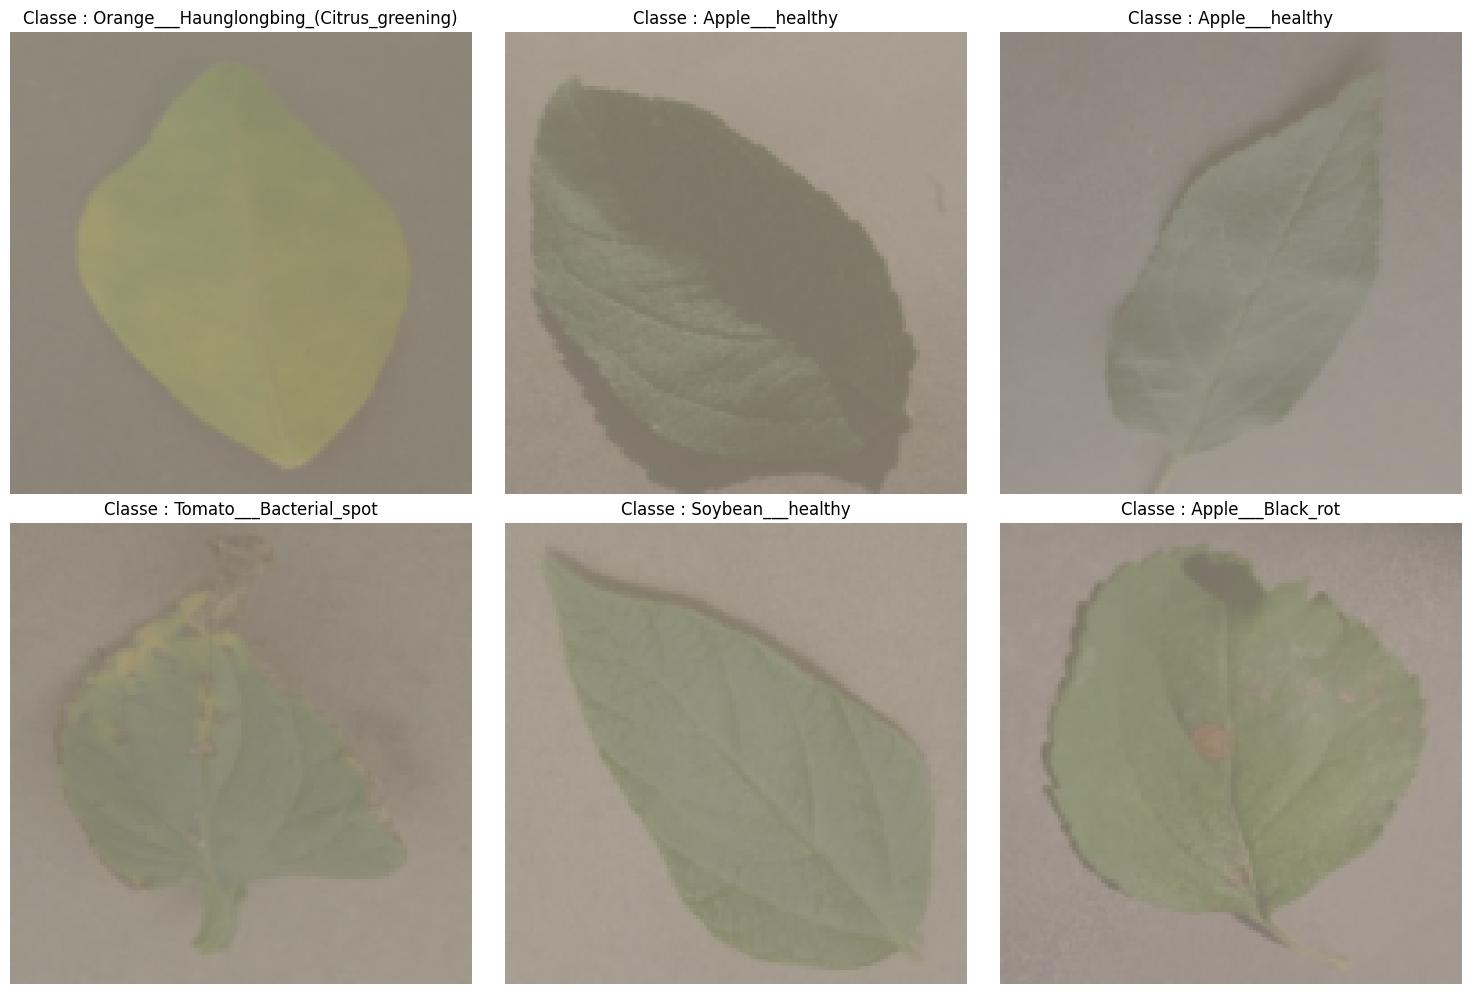

In [4]:
def show_dataset_examples(loader, classes, num_images=6):
    # Récupérer un lot d'images
    images, labels = next(iter(loader))

    plt.figure(figsize=(15, 10))

    for i in range(num_images):
        plt.subplot(2, 3, i + 1)

        # PyTorch utilise le format (C, H, W), on doit le remettre en (H, W, C) pour Matplotlib
        img = images[i].permute(1, 2, 0).numpy()

        # Annuler la normalisation ImageNet (moyenne et écart-type) pour l'affichage
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = std * img + mean
        img = np.clip(img, 0, 1) # S'assurer que les valeurs restent entre 0 et 1

        plt.imshow(img)
        plt.title(f"Classe : {classes[labels[i]]}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Utilisation
show_dataset_examples(train_loader, dataset.classes)

Construction de l'architecture du CNN

In [5]:
class PlantCNN(nn.Module):
    def __init__(self, num_classes):
        super(PlantCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        # Le calcul magique : 64 filtres * 32 (H) * 32 (W) = 65536
        self.fc1 = nn.Linear(64 * 32 * 32, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))) # Sortie: 32 filtres, 64x64
        x = self.pool(F.relu(self.conv2(x))) # Sortie: 64 filtres, 32x32

        x = torch.flatten(x, 1) # Transforme [32, 64, 32, 32] en [32, 65536]
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

Fonctionnement pour l'entraînement du modèle

In [6]:
def train_model(model, train_loader, test_loader, epochs=10):
    # Dictionary to store history
    history = {
        'train_loss': [], 'train_acc': [],
        'test_loss': [], 'test_acc': []
    }

    for epoch in range(epochs):
        model.train()
        train_loss, correct, total = 0, 0, 0

        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        # Record training metrics
        history['train_loss'].append(train_loss / len(train_loader))
        history['train_acc'].append(100. * correct / total)

        # Validation Phase
        model.eval()
        test_loss, test_correct, test_total = 0, 0, 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                _, predicted = outputs.max(1)
                test_total += labels.size(0)
                test_correct += predicted.eq(labels).sum().item()

        # Record validation metrics
        history['test_loss'].append(test_loss / len(test_loader))
        history['test_acc'].append(100. * test_correct / test_total)

        print(f"Epoch {epoch+1}: Train Acc {history['train_acc'][-1]:.2f}%, Test Acc {history['test_acc'][-1]:.2f}%")

    return history

In [7]:

#Setup Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

#Prepare Model
model = PlantCNN(num_classes=len(dataset.classes)).to(device)

# Optimizer & Loss
optimizer = optim.Adam(model.parameters(), lr=0.001) #on peut faire varier le learning rate
criterion = nn.CrossEntropyLoss()

# Run training and save history
history = train_model(model, train_loader, test_loader, epochs=10)

Using device: cuda


Epoch 1: 100%|██████████| 1358/1358 [01:38<00:00, 13.73it/s]


Epoch 1: Train Acc 46.72%, Test Acc 70.42%


Epoch 2: 100%|██████████| 1358/1358 [01:37<00:00, 13.96it/s]


Epoch 2: Train Acc 62.64%, Test Acc 77.25%


Epoch 3: 100%|██████████| 1358/1358 [01:36<00:00, 14.00it/s]


Epoch 3: Train Acc 67.75%, Test Acc 80.42%


Epoch 4: 100%|██████████| 1358/1358 [01:36<00:00, 14.05it/s]


Epoch 4: Train Acc 71.24%, Test Acc 80.34%


Epoch 5: 100%|██████████| 1358/1358 [01:36<00:00, 14.13it/s]


Epoch 5: Train Acc 73.84%, Test Acc 84.72%


Epoch 6: 100%|██████████| 1358/1358 [01:35<00:00, 14.15it/s]


Epoch 6: Train Acc 75.68%, Test Acc 85.61%


Epoch 7: 100%|██████████| 1358/1358 [01:35<00:00, 14.21it/s]


Epoch 7: Train Acc 77.78%, Test Acc 86.98%


Epoch 8: 100%|██████████| 1358/1358 [01:36<00:00, 14.13it/s]


Epoch 8: Train Acc 78.83%, Test Acc 86.09%


Epoch 9: 100%|██████████| 1358/1358 [01:37<00:00, 13.95it/s]


Epoch 9: Train Acc 80.00%, Test Acc 87.62%


Epoch 10: 100%|██████████| 1358/1358 [01:36<00:00, 14.15it/s]


Epoch 10: Train Acc 81.40%, Test Acc 87.64%


Fonction pour afficher l'historique du loss et de l'accuracy vs le nombre d'epochs réalisées

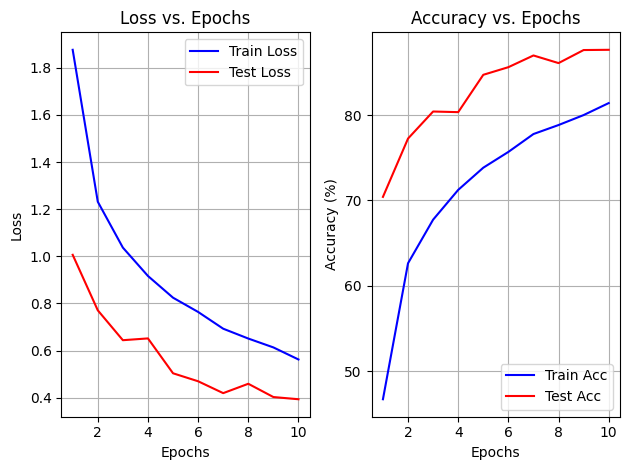

In [8]:

def plot_history(history):
    epochs = range(1, len(history['train_loss']) + 1)

    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], 'b-', label='Train Loss')
    plt.plot(epochs, history['test_loss'], 'r-', label='Test Loss')
    plt.title('Loss vs. Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], 'b-', label='Train Acc')
    plt.plot(epochs, history['test_acc'], 'r-', label='Test Acc')
    plt.title('Accuracy vs. Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig('my_learning_curves.png') # Saves the plot in Colab
    # plt.show() # Uncomment this in Colab to see it inline

plot_history(history)